# NLP 기초 Assignment
## NLP 제대로 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [2]:
# 필요한 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 8주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [3]:
spam = pd.read_csv('spam.csv')

In [4]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [5]:
spam.v1 = spam.v1.apply(lambda x : 0 if x == 'ham' else 1) # spam을 1 ham 을 0으로 변환해준다.

In [6]:
spam.v1.value_counts()[1]/ len(spam)

0.13406317300789664

- 비율을 확인해보면 spam인 경우가 전체의 13% 차지한다.

## Tokenizing
- 실습코드에서는 한국어 대상이라 konlpy를 다뤘지만, 영어는 nltk 모듈을 쓸 수 있습니다. 의미 있는 토큰으로 쪼개고 불용어도 처리해보세요! 현존하는 불용어 리스트를 사용해도 좋고, 새롭게 만들어도 좋습니다. 특수문자는 없애주고, 모두 소문자로 변환해주는 전처리도 필요하겠죠?

### re 모듈을 이용한 특수문자 제거

In [7]:
spam.v2[5569]

'Pity, * was in mood for that. So...any other suggestions?'

In [8]:
import re 
def cleanText(x) :
    x_ = re.sub('[^a-zA-Z]', ' ', x).lower() # 특수문자 제거 & 소문자 
    return x_

spam.v2 = spam.v2.apply(cleanText)

In [9]:
spam.v2[5569]

'pity    was in mood for that  so   any other suggestions '

In [10]:
spam.v2.nunique()

5147

In [11]:
test = spam.copy()
test1 = spam.copy()

### 불용어 처리 및 Tokenizing

- nltk에서 제공하는 tokenizer로 tokenizing을 진행하였다.

In [12]:
import nltk

# 예시 코드 코드
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords') # nltk에 저장되어 있는 불용어를 불러온다.
english_stops = list(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhgus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhgus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
token = []

for sentence in test.v2 : 
    words = word_tokenize(sentence) 
    words = [word for word in words if word not in english_stops]
    token.append(words)
    
test.v2 = token

In [14]:
test.v2

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, wkly, comp, win, fa, cup, final,...
3           [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, goes, usf, lives, around, though]
                              ...                        
5567    [nd, time, tried, contact, u, u, pound, prize,...
5568                      [b, going, esplanade, fr, home]
5569                            [pity, mood, suggestions]
5570    [guy, bitching, acted, like, interested, buyin...
5571                                   [rofl, true, name]
Name: v2, Length: 5572, dtype: object

- SentencePieceBPETokenizer는 Byte Pair Encoding으로 공백을 기준으로 단어를 구분하는데 각 빈도를 계산하여 가장 많이 나오는 글자 조합을 어휘에 추가하고 어휘 수에 도달할 때까지 반복한다
- 위의 nltk와 비교해보면 nltk에서는 미리 학습된 기준을 가지고 데이터에 적용하여 tokenizing을 하는 지도학습이라 생각하면, BPE 알고리즘은 데이터만을 이용하여 tokenizing을 진행하는 비지도 학습이라고 생각하면 된다.
- 각 나라 언어들로 미리 학습된 tokenizer (ex. nltk, konlpy, stanza)와 다르게 데이터의 단어들을 통해 학습이 되어 OOV 문제를 완화한다.
- huggingface에서 제공하는 tokenizers의 SentencePieceBPETokenizer를 사용한다.

In [15]:
from tokenizers import SentencePieceBPETokenizer

In [16]:
with open('test.txt', 'w', encoding= 'utf8') as f :
    for row in test1.itertuples() :
        f.write(row.v2 + '\n')

In [17]:
sp = SentencePieceBPETokenizer()
sp.train(files = 'test.txt', min_frequency = 1, vocab_size = 2000)

In [18]:
sp.get_vocab_size()

2000

In [19]:
word2idx = sp.get_vocab()
idx2word = {j:i for i,j in word2idx.items()}

In [20]:
def getlist(x) :
    tokens = sp.encode(x).tokens
    results = [token for token in tokens if token != '▁'] #의미없는 띄어쓰기는 제거 해준다.
    return results

In [21]:
test1.v2 = test1.v2.apply(getlist)

In [22]:
test1.v2

0       [▁go, ▁until, ▁j, ur, ong, ▁point, ▁crazy, ▁av...
1                [▁ok, ▁lar, ▁jo, king, ▁wif, ▁u, ▁on, i]
2       [▁free, ▁entry, ▁in, ▁a, ▁wkly, ▁comp, ▁to, ▁w...
3       [▁u, ▁dun, ▁say, ▁so, ▁early, ▁hor, ▁u, ▁c, ▁a...
4       [▁nah, ▁i, ▁don, ▁t, ▁think, ▁he, ▁goes, ▁to, ...
                              ...                        
5567    [▁this, ▁is, ▁the, ▁nd, ▁time, ▁we, ▁have, ▁tr...
5568    [▁will, ▁b, ▁going, ▁to, ▁es, pl, an, ade, ▁fr...
5569    [▁p, ity, ▁was, ▁in, ▁mo, od, ▁for, ▁that, ▁so...
5570    [▁the, ▁guy, ▁did, ▁some, ▁bit, ch, ing, ▁but,...
5571           [▁ro, f, l, ▁its, ▁true, ▁to, ▁its, ▁name]
Name: v2, Length: 5572, dtype: object

## Embedding

## 1. nltk 기반 one-hot encoding

 **CountVectorizer**  

- sklearn에서 제공하는 CountVectorizer를  one-hot encoding
- CountVectorizer는 단어의 출현 빈도에 여러 문서들을 벡터화 한다. 또한 대문자를 소문자로 변환시키기 때문에 따로 전처리가 필요하지 않다.
- 또한, 단순히 단어의 빈도수로 벡터화하기 때문에 BOW 인코딩 벡터로 결과를 변환한다.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
cv1 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False) 
cv2 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False) 

In [25]:
tokens_ham = sum(test[test.v1 == 0]['v2'], []) # CountVectorizer는 리스트 형태로 값이 들어와야 하기 때문에 이중 리스트를 flatten 시켜준다.
tokens_spam = sum(test[test.v1 == 1]['v2'], [])

In [26]:
tdm_ham = cv1.fit_transform(tokens_ham)
tdm_spam = cv2.fit_transform(tokens_spam)

- max_features : 단어의 빈도수를 기준으로 많이 나온 단어 상위 500개를 추출
- stop_words : 불용어처리를 위하 parameter, 사용자가 직접 list로 불용어를 작성해도 되고, 기존에 저장되어 있는 것을 사용해도 된다.
- lowercase : documents에 대문자로 되어 있는 부분을 소문자로 변환할 수 있다.

### 1.1 token 별 빈도수

In [27]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

In [28]:
word_counts_ham = pd.DataFrame(
    {'words' : cv1.get_feature_names(),
    'counts' : tdm_ham.sum(axis = 0).flat}
)

word_counts_spam = pd.DataFrame(
    {
        'words' : cv2.get_feature_names(),
        'counts' : tdm_spam.sum(axis = 0).flat
    }
)

In [29]:
word_counts_ham.sort_values('counts', ascending = False)

,words,counts
161,gt,318
247,lt,316
300,ok,287
157,got,245
453,ur,241
...,...,...
450,ugh,12
451,uncle,12
144,game,12
143,gal,12


In [30]:
word_counts_spam.sort_values('counts', ascending = False)

,words,counts
147,free,228
436,txt,170
446,ur,144
252,mobile,129
411,text,126
...,...,...
222,loan,4
438,txtin,4
212,largest,4
208,laid,4


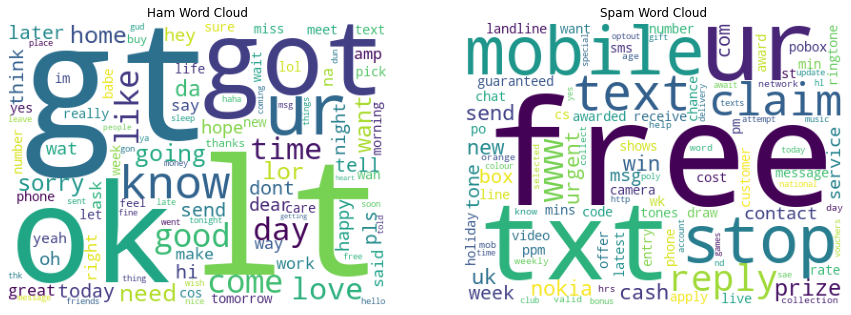

In [31]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.title('Ham Word Cloud')
count_dic = dict(zip(word_counts_ham['words'], word_counts_ham['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,2,2)
plt.title('Spam Word Cloud')
count_dic = dict(zip(word_counts_spam['words'], word_counts_spam['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)


plt.show()

- nltk로 tokenizing 후 spam, ham 데이터에 대한 token의 빈도수를 확인해 보면 위와 같다.
- Ham의 token들과 비교하면, Ham의 경우 good, know, want, ok 등과 같이 감정에 관련된 단어들이 많으면, Spam의 token들을 확인해 보면 특히 free에 대해서 강조를 하며, mobile,txt,chance, prize 등과 같이 제품에 대한 특징을 말하는 token들이 많은 것을 확인할 수 있다.  

- spam tokens의 빈도수 상위 10개에 대한 ham tokens의 빈도수
- 결과를 확인해 보면 7개의 words만 merge되는것을 볼 수 있는데 빈도수 차이가 많이 나는게 보인다.
- 단 ur 같은 경우 your의 줄임말로 이 부분은 spam과 ham 데이터에 자주 나오는것을 확인할 수 있다.

In [32]:
spam_words_list = word_counts_spam.sort_values('counts', ascending = False)['words'].tolist()[:10]
pd.merge(word_counts_ham.query('words in @spam_words_list'),word_counts_spam.query('words in @spam_words_list'),on = 'words',suffixes=('_ham', '_spam'))

,words,counts_ham,counts_spam
0,free,60,228
1,mobile,15,129
2,reply,44,104
3,stop,37,126
4,text,69,126
5,txt,14,170
6,ur,241,144


- ham tokens의 빈도수 상위 10개에 대한 spam tokens의 빈도수

In [33]:
ham_words_list = word_counts_ham.sort_values('counts', ascending = False)['words'].tolist()[:10]
pd.merge(word_counts_spam.query('words in @ham_words_list'),word_counts_ham.query('words in @ham_words_list'),on = 'words',suffixes=('_spam', '_ham'))

,words,counts_spam,counts_ham
0,day,26,216
1,good,12,233
2,got,7,245
3,know,25,236
4,like,13,232
5,ok,5,287
6,ur,144,241


### 1.2 token 별 가중치

In [54]:
cv = CountVectorizer(max_features= 500, stop_words = 'english', tokenizer=word_tokenize, lowercase= False) 

In [55]:
tdm = cv.fit_transform(spam.v2)
y = spam.v1

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tdm,y, test_size = 0.3, stratify = y, random_state = 555)

In [57]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [58]:
X_train.shape, X_test.shape

((3900, 500), (1672, 500))

In [59]:
import tensorflow as tf

In [61]:
# 간단한 Linear모델로 감성분석을 진행
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = (500,)))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 501       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

model.fit(X_train, y_train, epochs=10, batch_size = 128)

Epoch 1/10
31/31 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.6769
Epoch 2/10
31/31 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.8713
Epoch 3/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.9326
Epoch 4/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.9446
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.9495
Epoch 6/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4716 - accuracy: 0.9521
Epoch 7/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.9564
Epoch 8/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.9585
Epoch 9/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.9600
Epoch 10/10
31/31 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.9608


In [63]:
print('Valid loss : {} \nValid Acc : {}'.format(model.evaluate(X_test, y_test, verbose = 0)[0],model.evaluate(X_test, y_test, verbose = 0)[1]))

Valid loss : 0.37659281492233276 
Valid Acc : 0.9605262875556946


In [64]:
weights, bias = model.trainable_weights # Linear 모델의 weights와 bias를 받아 
# 이를 통해 spam에 대한 가중치들을 확인한다.

word_weight = pd.DataFrame({
    'words' : cv.get_feature_names(),
    'weights' : weights.numpy().flat
})

In [65]:
word_weight.sort_values('weights',ascending=False)[:20] # spam데이터에 대한 가중치

,words,weights
302,p,0.341891
329,prize,0.296393
161,guaranteed,0.295485
390,stop,0.287978
346,ringtone,0.285304
84,customer,0.279844
41,box,0.278271
65,claim,0.264803
38,bonus,0.255947
269,mths,0.255059


- 결과를 확인해 보면 p, prize 관련된 내용이 spam일 확률이 가장 크고, 그 다음 의미없는 데이터를 제거해 보면 txt, mobile이 가장 크다. 
- 또한 기존 wordcloud를 보면 prize ,guaranteed, claim, www, text 단어들이 빈도수가 큰데 모델의 weight도 큰 것을 볼 수 있다.
- 이 목록들을 확인해 보면 감정적인 단어들 보다. prize, guaranteed, claim, bonus 등과 같은 보상, 품질에 대한 단어들이 많을 수록 spam 데이터일 확률이 큰 것을 확인할 수 있다.

In [66]:
word_weight.sort_values('weights',ascending=True)[:20] # hamp 데이터에 대한 가중치

,words,weights
213,later,-0.332702
240,m,-0.321701
282,nice,-0.295460
351,s,-0.293657
293,ok,-0.292368
157,got,-0.288121
196,ill,-0.285537
185,home,-0.281490
48,buy,-0.278958
208,know,-0.277964


- 결과를 확인해 보면 later, nice, ok, dear 관련된 내용이 ham일 확률이 크고, wordcloud와 비교해도 어느 정도 빈도수가 있을 경우 가중치값이 큰 것을 확인할 수 있다.
- 또한 위의 spam 관련 데이터 보다 감정적인 단어 (nice, dear, sweet, happy 등) 같은 단어들이 ham일 가능성이 크다는것을 확인할 수 있다.

### 1.3 Word2vec

- word2vec을 이용하여 spam에 대한 가중치가 높은 상위 5개의 단어와 가장 유사한 단어들로 예측을 하였을 때 spam인지 ham인지 분류해본다.

In [67]:
from gensim.models import word2vec

In [68]:
w2v = word2vec.Word2Vec(test.v2.tolist(), size = 16, min_count=1, window=7, sg = 1) # Skip-gram Word2vec
w2v.init_sims(replace = True) # 필요없는 메모리 unload

**Spam 에 대한 가중치가 높은 top 5 단어들의 유사한 단어들의 감성분류**

In [76]:
words_list = word_weight.sort_values('weights',ascending=False)['words'][:5].tolist()
words_list.append('www')
for word in words_list :
    sim_words = ''
    for w,s in w2v.wv.most_similar(word, topn = 5) :
        sim_words += w
        sim_words += ' '
    pred = model.predict(cv.transform([sim_words]).toarray())[0][0]
    print('Base word : ',word)
    print('Total Sim_words : ',sim_words) 
    print('Result : ', np.where(pred>0.5, 'spam', 'ham'),'| Predict : ', pred)
    print('---------------------------------------------------------')

Base word :  p
Total Sim_words :  rate stop national pobox per 
Result :  spam | Predict :  0.66559935
---------------------------------------------------------
Base word :  prize
Total Sim_words :  guaranteed claim land valid urgent 
Result :  spam | Predict :  0.6921374
---------------------------------------------------------
Base word :  guaranteed
Total Sim_words :  land valid claim prize urgent 
Result :  spam | Predict :  0.69233084
---------------------------------------------------------
Base word :  stop
Total Sim_words :  p msg per rate unsubscribe 
Result :  spam | Predict :  0.6449043
---------------------------------------------------------
Base word :  ringtone
Total Sim_words :  colour camcorder mob txting motorola 
Result :  ham | Predict :  0.4775986
---------------------------------------------------------
Base word :  www
Total Sim_words :  uk co com tones wk 
Result :  spam | Predict :  0.6089841
---------------------------------------------------------


- 결과를 확인해 보면 www의 경우 com도 붙는것을 확인하면 인터넷 주소를 제공하는 데이터인 경우 spam일 가능성이 크고 
- prize 와 guaranteed을 보면 상품등에 대한 보상 및 품질에 대한 보장을 주장하면 spam일 가능성이 크다라고 생각할 수 있다.
- 즉, url로 이동시키려고 하는 데이터와, 무언가에 대한 보장 및 보상을 주장하는 데이터는 spam 데이터일 가능성이 크다.

**Ham 에 대한 가중치가 높은 top 5 단어들의 유사한 단어들의 감성분류**

In [80]:
words_list = word_weight.sort_values('weights',ascending=True)['words'][:5].tolist()
words_list.append('good')
for i, word in enumerate(words_list) :
    sim_words = ''
    if word not in w2v.wv.vocab :
        word = word_weight.sort_values('weights',ascending=True)['words'][i+5]
    for w,s in w2v.wv.most_similar(word, topn = 5) :
        sim_words += w
        sim_words += ' '
    pred = model.predict(cv.transform([sim_words]).toarray())[0][0]
    print('Base word : ',word)
    print('Total Sim_words : ',sim_words) 
    print('Result : ', np.where(pred>0.5, 'spam', 'ham'),'| Predict : ', pred)
    print('---------------------------------------------------------')

Base word :  later
Total Sim_words :  sorry tomorrow meeting tonight im 
Result :  ham | Predict :  0.23321712
---------------------------------------------------------
Base word :  afternoon
Total Sim_words :  thats money til called wake 
Result :  ham | Predict :  0.30197138
---------------------------------------------------------
Base word :  nice
Total Sim_words :  sleep babe said anything say 
Result :  ham | Predict :  0.2914076
---------------------------------------------------------
Base word :  ah
Total Sim_words :  eat v sch haha jus 
Result :  ham | Predict :  0.23006731
---------------------------------------------------------
Base word :  ok
Total Sim_words :  ask home going cos da 
Result :  ham | Predict :  0.24073765
---------------------------------------------------------
Base word :  good
Total Sim_words :  amp love morning day life 
Result :  ham | Predict :  0.2158621
---------------------------------------------------------


- ham일 가능성이 큰 단어들의 유사한 단어들을 확인해보면, sorry, haha, love 등 감정적인 단어들이 나온것을 확인할 수 있고 predict 한 결과 ham으로 분류될 가능성이 크다.
- 즉, 단순히 감정적인 단어들과, 일상적인 단어(sleep, eat, wake, home)들이 나오면 ham일 가능성이 크다.

## 2. BPE 알고리즘 기반 one-hot encoding

- 위의 nltk 기반 알고리즘과 동일하게 조건을 둔다.

### 2.1 token 별 빈도수

In [81]:
test1.head()

,v1,v2
0,0,"[▁go, ▁until, ▁j, ur, ong, ▁point, ▁crazy, ▁av..."
1,0,"[▁ok, ▁lar, ▁jo, king, ▁wif, ▁u, ▁on, i]"
2,1,"[▁free, ▁entry, ▁in, ▁a, ▁wkly, ▁comp, ▁to, ▁w..."
3,0,"[▁u, ▁dun, ▁say, ▁so, ▁early, ▁hor, ▁u, ▁c, ▁a..."
4,0,"[▁nah, ▁i, ▁don, ▁t, ▁think, ▁he, ▁goes, ▁to, ..."


In [82]:
cv3 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False) 
cv4 = CountVectorizer(max_features= 500, stop_words = 'english', lowercase= False) 

In [83]:
tokens_ham = sum(test1[test1.v1 == 0]['v2'], []) # CountVectorizer는 리스트 형태로 값이 들어와야 하기 때문에 이중 리스트를 flatten 시켜준다.
tokens_spam = sum(test1[test1.v1 == 1]['v2'], [])

In [84]:
tdm_ham = cv3.fit_transform(tokens_ham)
tdm_spam = cv4.fit_transform(tokens_spam)

In [85]:
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

In [86]:
word_counts_ham = pd.DataFrame(
    {'words' : cv3.get_feature_names(),
    'counts' : tdm_ham.sum(axis = 0).flat}
)

word_counts_spam = pd.DataFrame(
    {
        'words' : cv4.get_feature_names(),
        'counts' : tdm_spam.sum(axis = 0).flat
    }
)

In [87]:
word_counts_ham.sort_values('counts', ascending = False)

,words,counts
211,ing,589
108,ed,414
250,ll,367
454,ur,337
258,lt,327
...,...,...
390,ser,23
316,online,23
141,friendship,23
135,food,23


In [88]:
word_counts_spam.sort_values('counts', ascending = False)

,words,counts
141,free,241
445,txt,222
454,ur,156
428,text,140
414,stop,139
...,...,...
40,bl,6
38,bers,6
36,bc,6
300,ond,6


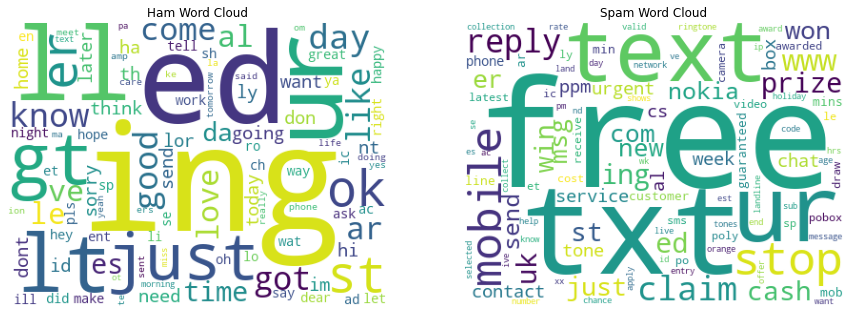

In [89]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.title('Ham Word Cloud')
count_dic = dict(zip(word_counts_ham['words'], word_counts_ham['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,2,2)
plt.title('Spam Word Cloud')
count_dic = dict(zip(word_counts_spam['words'], word_counts_spam['counts']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)


plt.show()

- BPE 알고리즘으로 tokenizing 후 spam, ham 데이터에 대한 token의 빈도수를 확인해 보면 위와 같다.
- 기존에 저장된 알고리즘으로 tokenizing을 하는 nltk의 wordcloud 와 비교해 보면 차이가 크지 않음을 확인할 수 있다.


### 2.2 token 별 가중치

In [103]:
def extract_words(text) :
    enc = sp.encode(text)
    return enc.tokens

In [104]:
cv_bpe = CountVectorizer(max_features= 500, tokenizer=extract_words, lowercase= False) 

In [105]:
tdm = cv_bpe.fit_transform(spam.v2)
y = spam.v1

In [106]:
X_train, X_test, y_train, y_test = train_test_split(tdm,y, test_size = 0.3, stratify = y, random_state = 555)

In [107]:
X_train = X_train.toarray()
X_test = X_test.toarray()

X_train.shape, X_test.shape

((3900, 500), (1672, 500))

In [121]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = (500,)))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 501       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

model.fit(X_train, y_train, epochs=10, batch_size = 128)

Epoch 1/10
31/31 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.7010
Epoch 2/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.8321
Epoch 3/10
31/31 [==============================] - 0s 1ms/step - loss: 0.4881 - accuracy: 0.9205
Epoch 4/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.9374
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3923 - accuracy: 0.9492
Epoch 6/10
31/31 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.9554
Epoch 7/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.9585
Epoch 8/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3113 - accuracy: 0.9615
Epoch 9/10
31/31 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.9633
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2763 - accuracy: 0.9659


In [123]:
print('Valid loss : {} \nValid Acc : {}'.format(model.evaluate(X_test, y_test, verbose = 0)[0],model.evaluate(X_test, y_test, verbose = 0)[1]))

Valid loss : 0.2780790627002716 
Valid Acc : 0.9515550136566162


In [124]:
weights, bias = model.trainable_weights # Linear 모델의 weights와 bias를 받아 
# 이를 통해 spam에 대한 가중치들을 확인한다.

word_weight = pd.DataFrame({
    'words' : cv_bpe.get_feature_names(),
    'weights' : weights.numpy().flat
})

word_weight.sort_values('weights',ascending=False)[:20] # spam데이터에 대한 가중치

,words,weights
448,▁txt,0.292229
393,▁service,0.284988
423,▁text,0.270953
450,▁uk,0.269935
373,▁prize,0.246971
182,▁com,0.242121
244,▁guaranteed,0.241318
186,▁contact,0.233092
174,▁cash,0.231907
337,▁nokia,0.208371


- 결과를 확인해 보면, nltk로 tokenizing 하여 학습한 결과와 비슷하게 나오는것을 확인할 수 있다. 
- txt, service, text, prize, com, guaranteed, cash, win등 위의 nltk랑 비슷하게 무언가에 대한 보상, 보장을 주장하면 spam일 가능성이 크다..

In [125]:
word_weight.sort_values('weights',ascending=True)[:20] # spam데이터에 대한 가중치

,words,weights
299,▁lol,-0.298439
344,▁oh,-0.292708
475,▁when,-0.290136
170,▁can,-0.287715
326,▁much,-0.283886
243,▁gt,-0.282933
275,▁it,-0.280603
491,▁ya,-0.279351
307,▁m,-0.277396
471,▁well,-0.275031


- ham의 경우에도 lol, oh, ya, haha, thk 같이 감정과 관련된 단어들이나, 일상생활에 자주 쓰이는 단어들일 경우 ham일 가능성이 크다.

### 2.3 Word2vec

In [126]:
w2v = word2vec.Word2Vec(test1.v2.tolist(), size = 16, min_count=1, window=7, sg = 1) # Skip-gram Word2vec
w2v.init_sims(replace = True) # 필요없는 메모리 unload

In [131]:
words_list = word_weight.sort_values('weights',ascending=False)['words'][:5].tolist()
words_list.append('▁www')
for word in words_list :
    sim_words = ''
    for w,s in w2v.wv.most_similar(word, topn = 5) :
        sim_words += w
        sim_words += ' '
    pred = model.predict(cv_bpe.transform([sim_words]).toarray())[0][0]
    print('Base word : ',word)
    print('Total Sim_words : ',sim_words) 
    print('Result : ', np.where(pred>0.5, 'spam', 'ham'),'| Predict : ', pred)
    print('---------------------------------------------------------')

Base word :  ▁txt
Total Sim_words :  ▁wk ▁tone ▁www ▁mates ▁music 
Result :  spam | Predict :  0.60272694
---------------------------------------------------------
Base word :  ▁service
Total Sim_words :  yal ▁customer ▁camera ▁offer ▁our 
Result :  spam | Predict :  0.51809645
---------------------------------------------------------
Base word :  ▁text
Total Sim_words :  ▁help ▁reply ▁credit ▁texts ▁get 
Result :  spam | Predict :  0.53026444
---------------------------------------------------------
Base word :  ▁uk
Total Sim_words :  zed ▁wq ones ▁http ▁age 
Result :  ham | Predict :  0.37667614
---------------------------------------------------------
Base word :  ▁prize
Total Sim_words :  ▁guaranteed ▁award ▁caller ▁receive ▁bonus 
Result :  spam | Predict :  0.6343595
---------------------------------------------------------
Base word :  ▁www
Total Sim_words :  zed ▁http ▁com ▁uk sc 
Result :  spam | Predict :  0.56662434
---------------------------------------------------------


- nltk의 결과와 유사하게 www의 경우 com도 붙는것을 확인하면 인터넷 주소를 제공하는 데이터인 경우 spam일 가능성이 크고
- prize 와 guaranteed을 보면 상품등에 대한 보상 및 품질에 대한 보장을 주장하면 spam일 가능성이 크다라고 생각할 수 있다.
- 즉, url로 이동시키려고 하는 데이터와, 무언가에 대한 보장 및 보상을 주장하는 데이터는 spam 데이터일 가능성이 크다.

In [132]:
words_list = word_weight.sort_values('weights',ascending=True)['words'][:5].tolist()
words_list.append('▁good')
for i, word in enumerate(words_list) :
    sim_words = ''
    if word not in w2v.wv.vocab :
        word = word_weight.sort_values('weights',ascending=True)['words'][i+5]
    for w,s in w2v.wv.most_similar(word, topn = 5) :
        sim_words += w
        sim_words += ' '
    pred = model.predict(cv_bpe.transform([sim_words]).toarray())[0][0]
    print('Base word : ',word)
    print('Total Sim_words : ',sim_words) 
    print('Result : ', np.where(pred>0.5, 'spam', 'ham'),'| Predict : ', pred)
    print('---------------------------------------------------------')

Base word :  ▁lol
Total Sim_words :  ▁wasn ▁bad ▁really ▁remember ▁alright 
Result :  spam | Predict :  0.51344883
---------------------------------------------------------
Base word :  ▁oh
Total Sim_words :  night ▁called ▁done ▁fine ▁felt 
Result :  ham | Predict :  0.42407912
---------------------------------------------------------
Base word :  ▁when
Total Sim_words :  ever ▁let ▁wont ▁didnt ▁talk 
Result :  ham | Predict :  0.49763012
---------------------------------------------------------
Base word :  ▁can
Total Sim_words :  ▁if ▁back ▁tonight ▁could ▁drive 
Result :  ham | Predict :  0.35255668
---------------------------------------------------------
Base word :  ▁much
Total Sim_words :  ▁things ▁always ▁many ▁boytoy ▁fine 
Result :  ham | Predict :  0.3870986
---------------------------------------------------------
Base word :  ▁good
Total Sim_words :  ▁morning ▁hope ▁night ▁day ▁very 
Result :  ham | Predict :  0.37238115
---------------------------------------------------

- ham일 가능성이 큰 단어들의 유사한 단어들을 확인해보면, oh, fine, hope 등 감정적인 단어들이 나온것을 확인할 수 있고 predict 한 결과 ham으로 분류될 가능성이 크다.

    결론적으로 기존에 저장되어 있는 알고리즘을 이용하여 tokenizing하는 nltk와 자기 데이터만의 규칙을 만들어 tokenizing하는 BPE 알고리즘의 결과를 상당히 유사하였다.
    
    Spam일 가능성이 큰 데이터들은 상품등에 대한 보상 및 품질에 대한 보장을 주장하고 외부 url이 들어간 데이터들이다.
      
    또한 Ham일 가능성이 큰 데이터들은 일상적인 단어들이나, 감정과 관련된 단어들이 나오는 경우 Ham일 가능성이 크다.